## Exoplanet candidate prediction using the KOI dataset

The Kepler Space Observatory is a NASA-build satellite that was launched in 2009 in the context of the [Kepler mission](https://www.nasa.gov/mission_pages/kepler/overview/index.html). The mission's target was to search for exoplanets in external star systems and ended in 2018. Kepler was able to find planets by looking for small dips in the brightness of a star when a planet *transits* in front of it.

*Note*: A transit occurs when a planet passes between a star and its observer. A planetary transit is described by parameters such as the period of recurrence, the duration of the transit and the fractional change in brightness of the star.

**Dataset**: a cumulative record of nearly 10k observed Kepler *objects of interest*, downloaded on 24th February 2022. An extensive data dictionary can be accessed [here](https://exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html).

**Contents**: The goal of this notebook is to classify observed Kepler *objects of interest* as **Planet Candidates** or **False Positives** (binary classification). The notebook is comprised of the below distinct sections:
1. *Exploratory Data Analysis*: where insight on the dataset and its features is provided.
2. *Pre-processing*: where things like null values, feature selection and train/test split are handled.
3. *Modelling*: where classification algorithms are applied and evaluated in terms of performance.

In [1]:
# imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, \
    GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, \
    recall_score, f1_score, roc_auc_score, confusion_matrix, \
    matthews_corrcoef

### Part 1 - Exploratory Data Analysis
The first section begins with an exploratory analysis of the dataset and its features. Main conclusions:
- There are 9564 data points and 49 attributes that describe them
- The target attributes to predict should be `koi_disposition` or/and `koi_pdisposition` or/and `koi_score`.
- Some attributes are unique identifiers and thus not necessary for the analysis:
  - `kepid`, `kepoi_name`, `kepler_name`
- Additionally, there are 22 attributes representing uncertainty estimates for other attributes:
  - `koi_period_err1`, `koi_period_err2`, `koi_time0bk_err1`, `koi_time0bk_err2`, `koi_impact_err1`, `koi_impact_err2`, `koi_duration_err1`, `koi_duration_err2`, `koi_depth_err1`, `koi_depth_err2`, `koi_prad_err1`, `koi_prad_err2`, `koi_teq_err1`, `koi_teq_err2`, `koi_insol_err1`, `koi_insol_err2`, `koi_steff_err1`, `koi_steff_err2`, `koi_slogg_err1`, `koi_slogg_err2`, `koi_srad_err1`, `koi_srad_err2`
- The majority of the attributes are floating point numeric values.

In [2]:
# import dataset
df = pd.read_csv('cumulative_2022.02.24_03.49.26.csv', skiprows=53) # 53 comment rows
print('Original dataset size:', df.shape)
# remove unnecessary attributes
df.drop(columns=[
    'kepid', # uid
    'kepoi_name', # uid
    'kepler_name', # uid
    'koi_period_err1', # uncertainty
    'koi_period_err2', # uncertainty
    'koi_time0bk_err1', # uncertainty
    'koi_time0bk_err2', # uncertainty
    'koi_impact_err1', # uncertainty
    'koi_impact_err2', # uncertainty
    'koi_duration_err1', # uncertainty
    'koi_duration_err2', # uncertainty
    'koi_depth_err1', # uncertainty
    'koi_depth_err2', # uncertainty
    'koi_prad_err1', # uncertainty
    'koi_prad_err2', # uncertainty
    'koi_teq_err1', # uncertainty
    'koi_teq_err2', # uncertainty
    'koi_insol_err1', # uncertainty
    'koi_insol_err2', # uncertainty
    'koi_steff_err1', # uncertainty
    'koi_steff_err2', # uncertainty
    'koi_slogg_err1', # uncertainty
    'koi_slogg_err2', # uncertainty
    'koi_srad_err1', # uncertainty
    'koi_srad_err2', # uncertainty
    'koi_tce_delivname', # tce categorical
    'koi_tce_plnt_num' # tce numerical
], inplace=True)
#
print('Reduced dataset size:', df.shape)

Original dataset size: (9564, 49)
Reduced dataset size: (9564, 22)


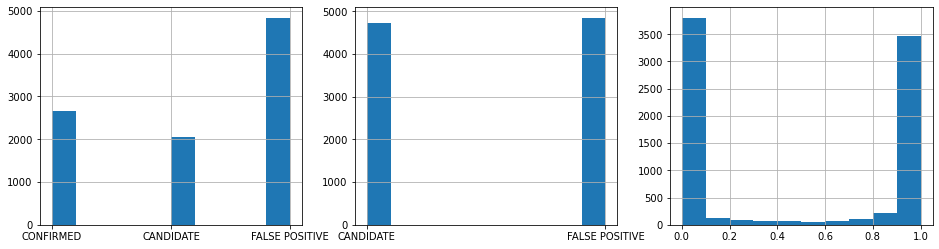

In [3]:
# target distributions
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4))
df['koi_disposition'].hist(ax=ax1)
df['koi_pdisposition'].hist(ax=ax2)
df['koi_score'].hist(ax=ax3)
plt.show()

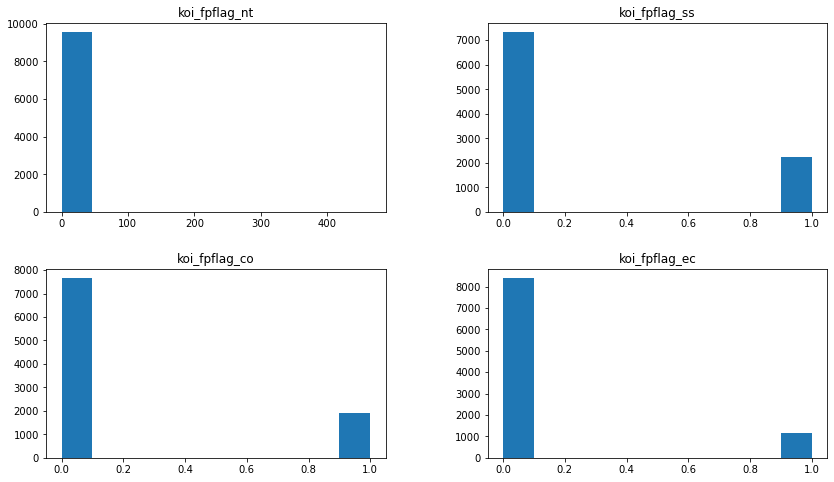

In [4]:
# integer features
num_features = [f for f in df.columns if df[f].dtype == np.int64] # numerical features
_ = df.hist(column=num_features, figsize=(14,8), grid=False) # histograms

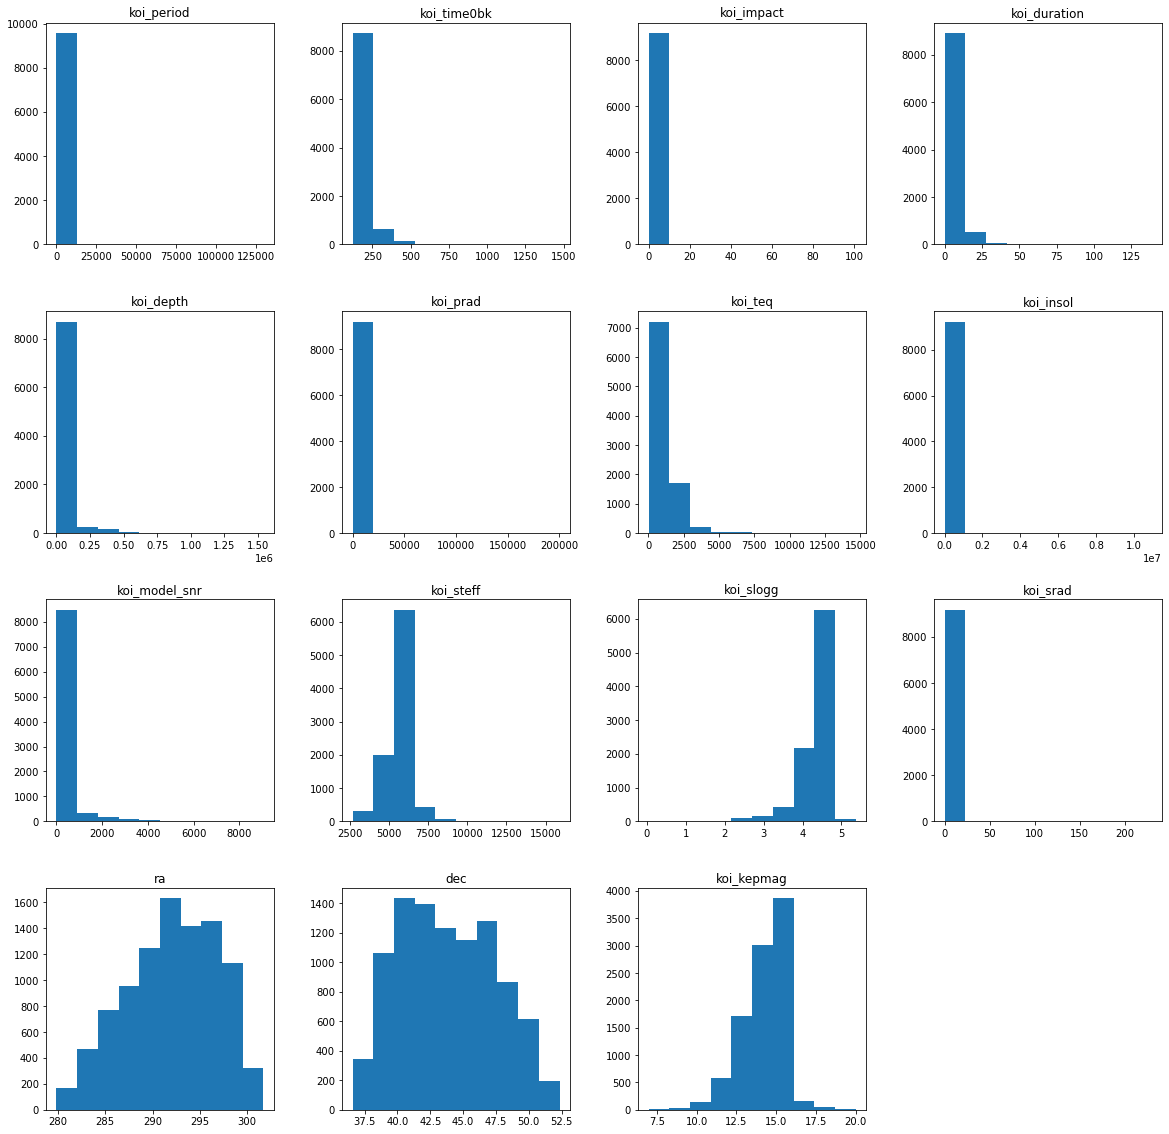

In [5]:
# float features
num_features = [f for f in df.columns if df[f].dtype == np.float64 and f != 'koi_score'] # numerical features
_ = df.hist(column=num_features, figsize=(20,20), grid=False) # histograms

### Part 2 - Pre-processing
This section handles na values, feature pre-processing and selection. Main points:
- Since the number of available data points is sufficient, rows that contain na values at this point are entirely removed.
- `koi_pdisposition` is selected as the target attribute after consulting the data dictionary and description.
- Feature selection and importance is depicted. Unimportant features are removed.
- A 2/3 vs 1/3 train/test split concludes this section.

In [6]:
# na values
df.dropna(inplace=True)
print('Dataset size after removing na values:', df.shape)

Dataset size after removing na values: (7994, 22)


In [7]:
# mapping
mapping = {
    'CANDIDATE': 1,
    'FALSE POSITIVE': 0
}
# target
df['y'] = df['koi_pdisposition'].map(mapping)
# linear correlation
df.corr()['y'].sort_values()

koi_fpflag_ss   -0.614813
koi_fpflag_co   -0.546577
koi_fpflag_ec   -0.405155
koi_teq         -0.341328
koi_depth       -0.306370
koi_model_snr   -0.279680
koi_impact      -0.223875
koi_steff       -0.197131
ra              -0.168853
koi_duration    -0.152401
koi_prad        -0.079845
koi_srad        -0.078433
koi_insol       -0.044744
koi_fpflag_nt   -0.009427
koi_period      -0.008652
koi_time0bk      0.027882
koi_kepmag       0.047249
dec              0.094919
koi_slogg        0.161169
koi_score        0.909220
y                1.000000
Name: y, dtype: float64

In [8]:
# target
y = df['y']
# features
X = df.drop(columns=['koi_disposition', 'koi_pdisposition', 'koi_score', 'y'])
feat_names = X.columns # feature names
print('Feature set size:', X.shape)
print('Feature names:\n', feat_names)

Feature set size: (7994, 19)
Feature names:
 Index(['koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec',
       'koi_period', 'koi_time0bk', 'koi_impact', 'koi_duration', 'koi_depth',
       'koi_prad', 'koi_teq', 'koi_insol', 'koi_model_snr', 'koi_steff',
       'koi_slogg', 'koi_srad', 'ra', 'dec', 'koi_kepmag'],
      dtype='object')


In [9]:
# feature selection/importance
k = len(feat_names) # keep all features
k_best = SelectKBest(k=k) # metric: f_classif
X = k_best.fit_transform(X, y)
print('ANOVA F-values:')
for i in range(len(feat_names)):
    print(feat_names[i], ' '*(15-len(feat_names[i])), '\t', '{:.3f}'.format(k_best.scores_[i]))

ANOVA F-values:
koi_fpflag_nt    	 0.710
koi_fpflag_ss    	 4856.768
koi_fpflag_co    	 3404.725
koi_fpflag_ec    	 1569.531
koi_period       	 0.598
koi_time0bk      	 6.218
koi_impact       	 421.694
koi_duration     	 190.036
koi_depth        	 827.854
koi_prad         	 51.277
koi_teq          	 1053.889
koi_insol        	 16.032
koi_model_snr    	 678.189
koi_steff        	 323.132
koi_slogg        	 213.131
koi_srad         	 49.469
ra               	 234.550
dec              	 72.660
koi_kepmag       	 17.882


In [10]:
# split to train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
# label distributions
print('Training labels:\n', y_train.value_counts())
print('\nTest labels:\n', y_test.value_counts())

Training labels:
 1    2749
0    2606
Name: y, dtype: int64

Test labels:
 1    1345
0    1294
Name: y, dtype: int64


### Part 3 - Modeling
This section trains a classifier to predict `koi_pdisposition` label. Main points:
- **Random forest** and **Gradient boosting** classifiers achieve superior performance.
- The subset of the features used for fit affects the test set performance. After experimentation, it was decided that all 19 features can be used to obtain the best performance.
- Performance metrics showcased include accuracy, precision, recall, f1 score and roc auc score. The confusion matrix is also provided.

In [11]:
# fit
clf = RandomForestClassifier() # GradientBoostingClassifier could be used as well
clf.fit(X_train, y_train)
# metrics
y_pred = clf.predict(X_test)
print('Accuracy:\t', accuracy_score(y_test, y_pred))
print('Precision:\t', precision_score(y_test, y_pred))
print('Recall:\t\t', recall_score(y_test, y_pred))
print('f1 score:\t', f1_score(y_test, y_pred))
print('ROC AUC score:\t', roc_auc_score(y_test, y_pred))
print('Matthews correlation coefficient:', matthews_corrcoef(y_test, y_pred))
# confusion matrix
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred))

Accuracy:	 0.9981053429329292
Precision:	 1.0
Recall:		 0.9962825278810409
f1 score:	 0.9981378026070763
ROC AUC score:	 0.9981412639405205
Matthews correlation coefficient: 0.9962167044142635
Confusion matrix:
[[1294    0]
 [   5 1340]]
